# Homework 3

### Notebook by: Christian Cabral

In [57]:
import numpy as np
import pandas as pd

In [58]:
# according to documentation, sep parameter is ',' by default
# since the columns in the csv file is separated by ';', set sep=';'
df = pd.read_csv("../../Datasets/bank/bank-full.csv", sep=';')

In [59]:
# y = subscribed a term deposit or not. 
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Data Preparation

In [60]:
# all columns without default
cols = ['age', 'job', 'marital', 'education', 'balance',
'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
'previous', 'poutcome', 'y']

In [61]:
df = df[cols]

In [62]:
df.isna().any()

age          False
job          False
marital      False
education    False
balance      False
housing      False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

In [63]:
df.value_counts()

age  job         marital   education  balance  housing  contact    day  month  duration  campaign  pdays  previous  poutcome  y  
18   student     single    primary    608      no       cellular   12   aug    267       1         -1     0         unknown   yes    1
45   management  married   tertiary   0        no       cellular   11   aug    102       4         -1     0         unknown   no     1
                 divorced  tertiary   1        no       cellular   6    aug    490       2         -1     0         unknown   yes    1
                                      54       no       cellular   21   jul    34        3         -1     0         unknown   no     1
                                      220      yes      unknown    18   jun    89        4         -1     0         unknown   no     1
                                                                                                                                    ..
35   admin.      married   secondary  34       yes      cell

Notice the *unknown* values

In [64]:
numerical_variables = df.select_dtypes('number').columns.to_list()
categorical_variables = ['job',
  'marital',
  'education',
  'housing',
  'contact',
  'month',
  'poutcome']

In [65]:
numerical_variables, categorical_variables

(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'],
 ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome'])

Columns with "unknown" values:

In [66]:
df[categorical_variables].apply(lambda x: print(x.name) if x.str.contains('unknown').any() else None, axis=0);

job
education
contact
poutcome


# Question 1

In [67]:
df.y = (df.y == 'yes').astype(int)

In [68]:
df.education.mode()

0    secondary
Name: education, dtype: object

# Question 2

### Correlation Score

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
# extract correlation
corr_matrix = df[numerical_variables].corr()

In [71]:
# fill diagonals with 0, by default it is 1.
np.fill_diagonal(corr_matrix.values, 0)

In [72]:
corr_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)

,age,balance,day,duration,campaign,pdays,previous
age,0.00,0.10,-0.01,-0.00,0.00,-0.02,0.00
balance,0.10,0.00,0.00,0.02,-0.01,0.00,0.02
day,-0.01,0.00,0.00,-0.03,0.16,-0.09,-0.05
duration,-0.00,0.02,-0.03,0.00,-0.08,-0.00,0.00
campaign,0.00,-0.01,0.16,-0.08,0.00,-0.09,-0.03
pdays,-0.02,0.00,-0.09,-0.00,-0.09,0.00,0.45
previous,0.00,0.02,-0.05,0.00,-0.03,0.45,0.00


<Axes: title={'center': 'Correlation between variables'}>

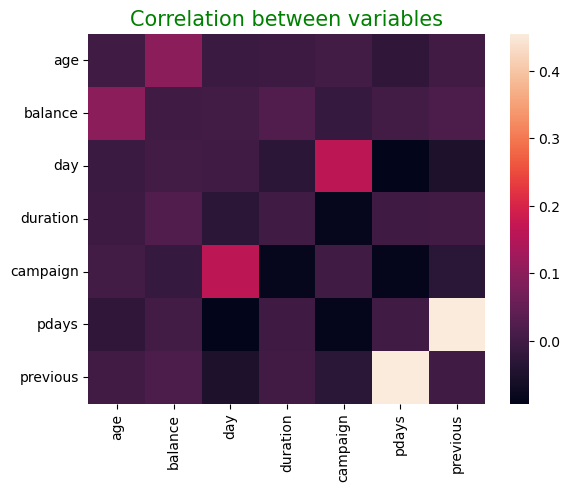

In [119]:
plt.title('Correlation between variables', color='green', fontsize=15)
sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values)

# Question 3

In [74]:
corr_matrix.max()

age         0.097783
balance     0.097783
day         0.162490
duration    0.021560
campaign    0.162490
pdays       0.454820
previous    0.454820
dtype: float64

### Mutual Information Score

In [75]:
from sklearn.metrics import mutual_info_score
# from IPython.display import display

In [76]:
scores = {}

In [77]:
for column in categorical_variables:
    score = mutual_info_score(df.y, df[column])
    scores[column] = round(score, 2)

# Question 4

In [78]:
scores

{'job': 0.01,
 'marital': 0.0,
 'education': 0.0,
 'housing': 0.01,
 'contact': 0.01,
 'month': 0.02,
 'poutcome': 0.03}

### Data Splitting

In [79]:
from sklearn.model_selection import train_test_split

In [80]:
# 60 20 20 split
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=len(df_test), random_state=42)

train_full_y = df_train_full.values
test_y = df_test.y.values
train_y = df_train.y.values
val_y = df_val.y.values

del df_test['y']
del df_train['y']
del df_val['y']
del df_train_full['y']

In [81]:
len(df_train), len(df_val), len(df_test)

(27125, 9043, 9043)

In [82]:
len(train_y), len(val_y), len(test_y)

(27125, 9043, 9043)

### One-hot encoding

In [90]:
from sklearn.feature_extraction import DictVectorizer
# initialize dictvectorizer
dv = DictVectorizer(sparse=False)
full_train_dict = df_train_full.to_dict(orient='records')
# fit dv
dv.fit(full_train_dict)

X_train = dv.transform(df_train.to_dict(orient='records'))
X_val = dv.transform(df_val.to_dict(orient='records'))
X_test = dv.transform(df_test.to_dict(orient='records'))
X_full = dv.transform(full_train_dict)

### Training the model

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, train_y)
val_predictions = model.predict(X_val)

# accuracy
original_accuracy = accuracy_score(val_predictions, val_y)
np.round(original_accuracy, 2), original_accuracy

(0.9, 0.9011390025434037)

In [92]:
# just to see weights
# dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'age': 0.001,
 'balance': 0.0,
 'campaign': -0.082,
 'contact=cellular': 0.25,
 'contact=telephone': 0.07,
 'contact=unknown': -1.322,
 'day': 0.01,
 'duration': 0.004,
 'education=primary': -0.439,
 'education=secondary': -0.252,
 'education=tertiary': -0.068,
 'education=unknown': -0.241,
 'housing=no': -0.148,
 'housing=yes': -0.853,
 'job=admin.': 0.095,
 'job=blue-collar': -0.223,
 'job=entrepreneur': -0.263,
 'job=housemaid': -0.354,
 'job=management': -0.087,
 'job=retired': 0.243,
 'job=self-employed': -0.291,
 'job=services': -0.117,
 'job=student': 0.304,
 'job=technician': -0.152,
 'job=unemployed': 0.045,
 'job=unknown': -0.2,
 'marital=divorced': -0.351,
 'marital=married': -0.475,
 'marital=single': -0.175,
 'month=apr': -0.009,
 'month=aug': -0.718,
 'month=dec': 0.43,
 'month=feb': -0.324,
 'month=jan': -1.249,
 'month=jul': -1.042,
 'month=jun': 0.303,
 'month=mar': 1.508,
 'month=may': -0.51,
 'month=nov': -0.966,
 'month=oct': 0.767,
 'month=sep': 0.809,
 'pdays': -

### Feature Elimination

In [114]:
accuracy = []

for excluded_feature in ['age', 'previous', 'balance', 'marital']:
    # train with features excluding the current feature in the loop
    dv = DictVectorizer(sparse=False)
    feature_train = dv.fit_transform(df_train.drop(columns=excluded_feature).to_dict(orient='records'))
    feature_val = dv.transform(df_val.drop(columns=excluded_feature).to_dict(orient='records'))
    # fit new model with current features and make predictions
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(feature_train, train_y)
    predictions = (model.predict_proba(feature_val)[:,1] >= 0.5)
    
    # calculate accuracy
    acc = accuracy_score(val_y, predictions)
    
    accuracy.append((excluded_feature, original_accuracy, acc, original_accuracy - acc))

In [115]:
df_results = pd.DataFrame(data=accuracy, columns=["excluded_feature", "original_accuracy", "accuracy", "difference"])

# Question 5

In [116]:
df_results.sort_values(by="difference")

,excluded_feature,original_accuracy,accuracy,difference
0,age,0.901139,0.900918,0.000221
2,balance,0.901139,0.900697,0.000442
1,previous,0.901139,0.900586,0.000553
3,marital,0.901139,0.900254,0.000885


### Regularization

# Question 6

In [117]:
Cs = [0.01, 0.1, 1, 10, 100]
results = []
for c in Cs:
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=42)
    model.fit(X_train, train_y)

    predictions = model.predict(X_val)
    acc = accuracy_score(predictions, val_y)
    results.append((c, round(acc, 3)))
results

[(0.01, 0.898), (0.1, 0.901), (1, 0.901), (10, 0.901), (100, 0.901)]

**0.01** seems to be the answer.